In [1]:
import pandas as pd
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN

In [5]:
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

In [39]:
import regex as re

In [7]:
df = pd.read_csv('MA_disaster_combined.csv')
ma_ID=df['maId']

In [9]:
column_list=['year','day','index','incidentId','state','incidentType','region_x','maType','maPriority',
            'supportFunction','agencyId','declarationType','maId']

In [11]:
df.drop(columns=column_list, inplace=True)

In [13]:
df.head()

,DOI-USGS,VA,USDA-FS,USDA-APH,HUD,HHS-ASPR,GSA,EPA,DOT,DOJ-ATF,...,Toxic Substances,Chemical,Terrorist,Human Cause,Tsunami,Civil Unrest,Nuclear,Explosion,Tidal Wave,month
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


In [19]:
def sparse_reduce(df, components):
    X = df.to_numpy()
    return SparsePCA(n_components=components,random_state=42).fit_transform(X)

In [49]:
#function for kmeans to explore different numbers of clusters
def kmeans(data, num_cluster):
    return KMeans(n_clusters=num_cluster, random_state=42, n_init=10).fit_predict(data)
    

In [51]:
#function for agglomerative clustering to explore different numbers of clusters
def agg_cluster(data, num_cluster):
    return AgglomerativeClustering(n_clusters=num_cluster).fit_predict(data)
    

In [57]:
#function for DBSCAN
def dbscan(data):
    return DBSCAN().fit_predict(data)

In [59]:
#function for HDBSCAN
def hdbscan(data):
    return HDBSCAN().fit_predict(data)

In [27]:
#function to generate scree plots to determine number of principal components
def scree_plot(df, title):

    X = df.to_numpy()

    comps = SparsePCA().fit(X)

    plt.plot(comps.explained_variance_ratio_)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('Scree plot - {}'.format(title))
    plt.show()

In [45]:
#function that generates a heatmap to examine PCA loadings
def pca_heatmap(df, components, category):

    X = df.to_numpy()

    spca=SparsePCA(n_components=components,random_state=42).fit(X)
    
    pc=spca.components_
    col=df.columns.to_list()
    cols=[]
    for c in col:
        name=re.findall(r"(?:[A-Z].*!!)([A-Z].*)",c)
        cols.append(name)
    rows=list(range(components))

    #modified from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    fig, ax = plt.subplots(figsize=(20,40))
    im = ax.imshow(pc)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(cols)), labels=cols,
              rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(rows)), labels=rows)

    # Loop over data dimensions and create text annotations.
    fig.colorbar(plt.cm.ScalarMappable(),
             ax=ax, label="PC Loading", shrink=.1)
    
    ax.set_title("Loadings of principal components for {}".format(category))
    fig.tight_layout()
    plt.show()

In [21]:
#Employ sparse PCA to reduce data - start with 4 components.  Returns numpy array of transformed data
spca = sparse_reduce(df, 4)

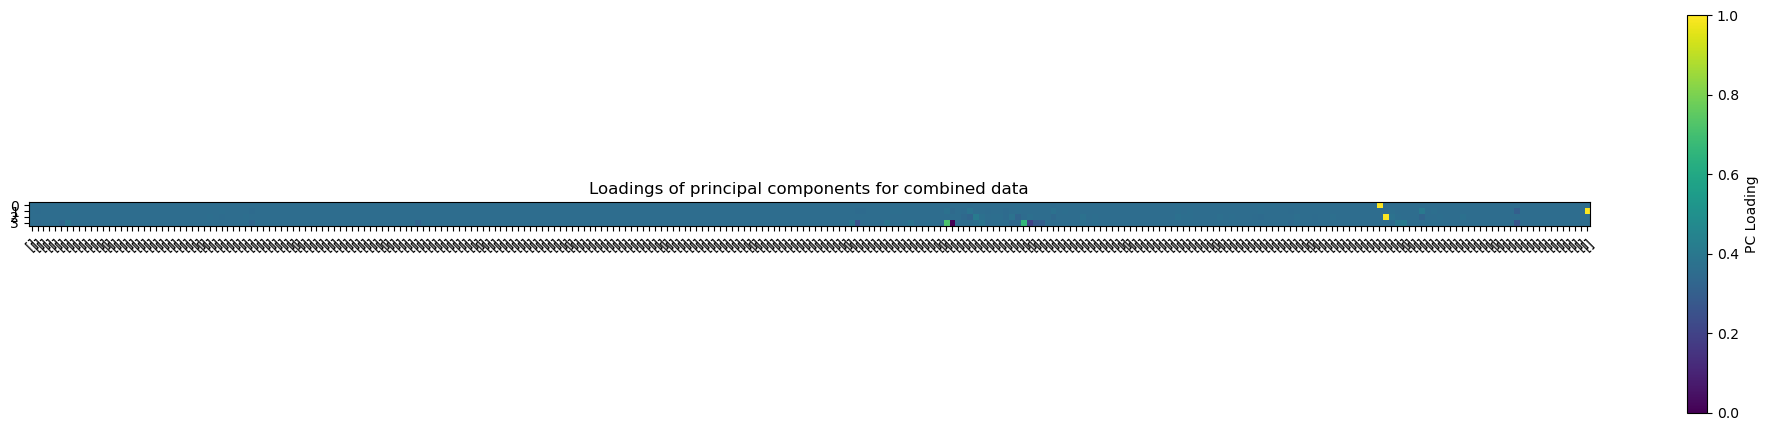

In [47]:
pca_heatmap(df, 4, 'combined data')

Davies-Bouldin Index: 0.5173074758630988 Num clusters: 3
Calinski-Harabasz Index: 21717.38875247494 Num clusters: 5
Silhouette Score: 0.599776870924554 Num clusters: 3


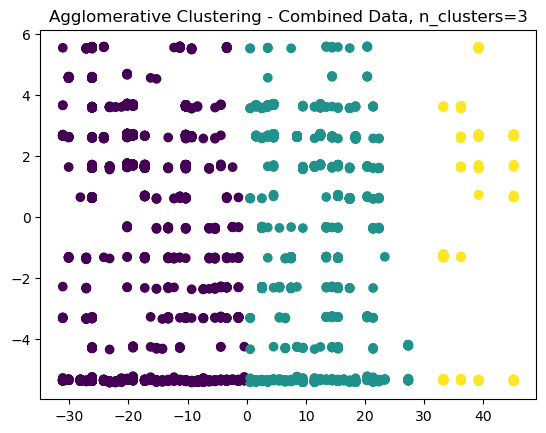

In [53]:
#initialize variables for metrics.  Variable was initialized with the 'worst' score.  Loop created to iterate from 
#2 to 10 clusters and best score retained.  Scatter plot of best cluster is generated.
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    clusters=agg_cluster(spca,k)

    dav_bou_score = davies_bouldin_score(spca,clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(spca,clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(spca,clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

clusters=agg_cluster(spca,best_silh_k)
plt.scatter(spca[:,0], spca[:,1], c=clusters)
plt.title('Agglomerative Clustering - Combined Data, n_clusters={}'.format(best_silh_k))
plt.show()

Davies-Bouldin Index: 0.517681236823919 Num clusters: 3
Calinski-Harabasz Index: 23827.867881110153 Num clusters: 5
Silhouette Score: 0.6061543375757742 Num clusters: 3


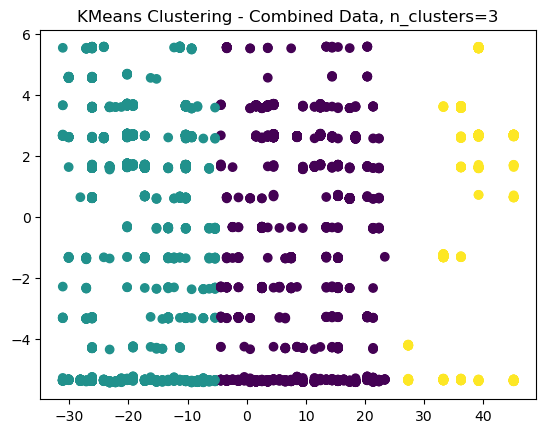

In [55]:
#initialize variables for metrics.  Variable was initialized with the 'worst' score.  Loop created to iterate from 
#2 to 10 clusters and best score retained.  Scatter plot of best cluster is generated.
db_best=1
ch_best=0
silh_best=-1
best_db_k=0
best_ch_k=0
best_silh_k=0
for k in range(2,11):
    clusters=kmeans(spca,k)

    dav_bou_score = davies_bouldin_score(spca,clusters)
    if dav_bou_score<db_best:
        db_best=dav_bou_score
        best_db_k=k

    cal_har_score=calinski_harabasz_score(spca,clusters)
    if cal_har_score>ch_best:
        ch_best=cal_har_score
        best_ch_k=k

    silh_score=silhouette_score(spca,clusters)
    if silh_score>silh_best:
        silh_best=silh_score
        best_silh_k=k

print("Davies-Bouldin Index:", db_best, "Num clusters:", best_db_k)
print("Calinski-Harabasz Index:", ch_best, "Num clusters:", best_ch_k)
print("Silhouette Score:", silh_best, "Num clusters:", best_silh_k)

clusters=kmeans(spca,best_silh_k)
plt.scatter(spca[:,0], spca[:,1], c=clusters)
plt.title('KMeans Clustering - Combined Data, n_clusters={}'.format(best_silh_k))
plt.show()

Silhouette Score: 0.5124569688510674 Num clusters: 191


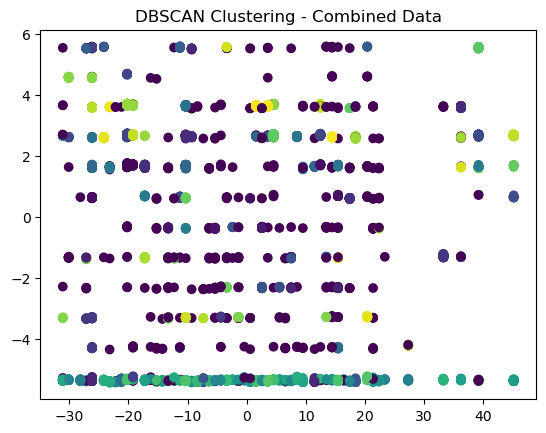

In [63]:
#initialize variables for metrics.  Variable was initialized with the 'worst' score.  Loop created to iterate from 

clusters=dbscan(spca)

silh_score=silhouette_score(spca,clusters)

print("Silhouette Score:", silh_score, "Num clusters:", len(np.unique(clusters)))

plt.scatter(spca[:,0], spca[:,1], c=clusters)
plt.title('DBSCAN Clustering - Combined Data')
plt.show()

In [71]:
np.unique(clusters)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

Silhouette Score: 0.5884723581439193 Num clusters: 635


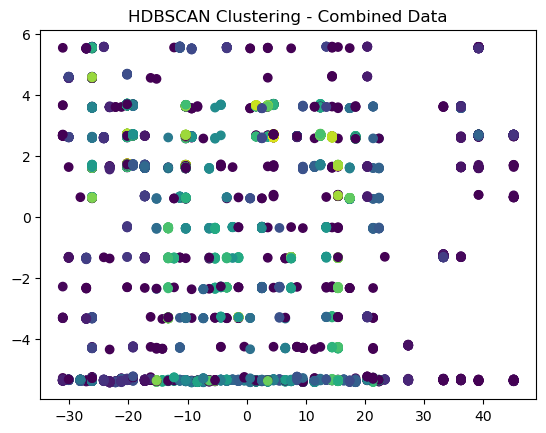

In [75]:
#initialize variables for metrics.  Variable was initialized with the 'worst' score.  Loop created to iterate from 
clusters=hdbscan(spca)

silh_score=silhouette_score(spca,clusters)

print("Silhouette Score:", silh_score, "Num clusters:", len(np.unique(clusters)))

plt.scatter(spca[:,0], spca[:,1], c=clusters)
plt.title('HDBSCAN Clustering - Combined Data')
plt.show()